<a href="https://colab.research.google.com/github/a-mhamdi/jlai/blob/main/Codes/Julia/Part-3/cnn/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HANDWRITTEN DIGITS RECOGNITION USING CNN
---

This notebook demonstrates handwritten digit classification using a **Convolutional Neural Network** (**CNN**). The implementation utilizes the `Flux.jl` library in Julia, with `CUDA.jl` for **GPU** acceleration.

## Project Setup

In [1]:
versioninfo()

Julia Version 1.11.5
Commit 760b2e5b739 (2025-04-14 06:53 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 2 × Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LLVM: libLLVM-16.0.6 (ORCJIT, broadwell)
Threads: 2 default, 0 interactive, 1 GC (on 2 virtual cores)
Environment:
  LD_LIBRARY_PATH = /usr/lib64-nvidia
  JULIA_NUM_THREADS = auto


In [2]:
# ;wget -O Project.toml https://raw.githubusercontent.com/a-mhamdi/jlai/refs/heads/main/Codes/Julia/Part-3/cnn/Project.toml

In [3]:
# ;sed -i -e '/^Pl[uo]/d' -e '/^Image/d' Project.toml

We write the package dependencies to a `Project.toml` file. This file is used by Julia's package manager `Pkg` to specify the exact versions of the packages needed here.

In [4]:
pkgs = """[deps]
BSON = "fbb218c0-5317-5bc6-957e-2ee96dd4b1f0"
CUDA = "052768ef-5323-5732-b1bb-66c8b64840ba"
CairoMakie = "13f3f980-e62b-5c42-98c6-ff1f3baf88f0"
Flux = "587475ba-b771-5e3f-ad9e-33799f191a9c"
ImageInTerminal = "d8c32880-2388-543b-8c61-d9f865259254"
ImageShow = "4e3cecfd-b093-5904-9786-8bbb286a6a31"
JLD2 = "033835bb-8acc-5ee8-8aae-3f567f8a3819"
MLDatasets = "eb30cadb-4394-5ae3-aed4-317e484a6458"
Markdown = "d6f4376e-aef5-505a-96c1-9c027394607a"
ProgressMeter = "92933f4c-e287-5a05-a399-4b506db050ca"
Statistics = "10745b16-79ce-11e8-11f9-7d13ad32a3b2"
cuDNN = "02a925ec-e4fe-4b08-9a7e-0d78e3d38ccd"
"""

open("Project.toml", "w") do file
    write(file, pkgs)
end

607

Activate the project environment and instantiates the packages listed in the `Project.toml` file.

In [ ]:
_ = begin
  import Pkg;
  Pkg.activate(".");
  Pkg.instantiate();
end

Status of the installed packages in the current environment, showing their versions and any compatibility issues.

In [6]:
Pkg.status()

Status `/content/Project.toml`
  [fbb218c0] BSON v0.3.9
  [052768ef] CUDA v5.9.2
  [13f3f980] CairoMakie v0.15.6
  [587475ba] Flux v0.16.5
  [d8c32880] ImageInTerminal v0.5.4
  [4e3cecfd] ImageShow v0.3.8
⌅ [033835bb] JLD2 v0.5.15
  [eb30cadb] MLDatasets v0.7.18
  [92933f4c] ProgressMeter v1.11.0
  [10745b16] Statistics v1.11.1
  [02a925ec] cuDNN v1.4.6
  [d6f4376e] Markdown v1.11.0
Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated`


Import the `Flux` library, which is essential for building and training the neural network.

In [7]:
using Flux
using Flux: DataLoader
using Flux: onecold, onehotbatch

Import the `CUDA` package and displays information about the `CUDA` version and available **GPU** devices.

In [8]:
using CUDA
CUDA.versioninfo()

CUDA toolchain: 
- runtime 12.5, local installation
- driver 550.54.15 for 13.0
- compiler 12.9

CUDA libraries: 
- CUBLAS: 12.5.3
- CURAND: 10.3.6
- CUFFT: 11.2.3
- CUSOLVER: 11.6.3
- CUSPARSE: 12.5.1
- CUPTI: 2024.2.1 (API 12.5.0)
- NVML: 12.0.0+550.54.15

Julia packages: 
- CUDA: 5.9.2
- CUDA_Driver_jll: 13.0.2+0
- CUDA_Compiler_jll: 0.3.0+0
- CUDA_Runtime_jll: 0.19.2+0
- CUDA_Runtime_Discovery: 1.0.0

Toolchain:
- Julia: 1.11.5
- LLVM: 16.0.6

Preferences:
- CUDA_Runtime_jll.version: 12.5.1
- CUDA_Runtime_jll.local: true

1 device:
  0: Tesla T4 (sm_75, 14.738 GiB / 15.000 GiB available)


## Load and process data

In [9]:
Base.@kwdef mutable struct HyperParams
    η = 3f-3                # Learning rate
    batchsize = 64          # Batch size
    epochs = 8              # Number of epochs
    split = :train          # Split data into `train` and `test`
end

HyperParams

Load the **MNIST** dataset

In [10]:
using MLDatasets

In [11]:
d = MNIST()

This program has requested access to the data dependency MNIST.
which is not currently installed. It can be installed automatically, and you will not see this message again.

Dataset: THE MNIST DATABASE of handwritten digits
Authors: Yann LeCun, Corinna Cortes, Christopher J.C. Burges
Website: http://yann.lecun.com/exdb/mnist/

[LeCun et al., 1998a]
    Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner.
    "Gradient-based learning applied to document recognition."
    Proceedings of the IEEE, 86(11):2278-2324, November 1998

The files are available for download at the offical
website linked above. Note that using the data
responsibly and respecting copyright remains your
responsibility. The authors of MNIST aren't really
explicit about any terms of use, so please read the
website to make sure you want to download the
dataset.



Do you want to download the dataset from ["https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz", "https://ossci-datasets.s3.amazonaws.com/mn

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :train
  features  =>    28×28×60000 Array{Float32, 3}
  targets   =>    60000-element Vector{Int64}

The function `get_data` loads the MNIST dataset, normalizes the features by dividing by 255, reshapes the data to include a channel dimension, and one-hot encodes the labels. It then creates a `DataLoader` for efficient batching and moves the data to the GPU.

In [12]:
function get_data(; kws...)
    args = HyperParams(; kws...);
    # Split and normalize data
    data = MNIST(split=args.split);
    X, y = data.features ./ 255, data.targets;
    X = reshape(X, (28, 28, 1, :));
    y = onehotbatch(y, 0:9);
    loader = DataLoader((X, y); batchsize=args.batchsize, shuffle=true) |> gpu;
    return loader
end

get_data (generic function with 1 method)

In [13]:
train_loader = get_data();
test_loader = get_data(split=:test);

Check the type of the first batch of data from the `get_data` function. The output will indicate whether the data is stored as an `Array` (on the CPU) or a `CuArray` (on the GPU).

In [14]:
x1, y1 = first(get_data());
# CPU => Array...
# GPU => CuArray...
typeof((x1, y1))

Tuple{CuArray{Float32, 4, CUDA.DeviceMemory}, OneHotArrays.OneHotMatrix{UInt32, CuArray{UInt32, 1, CUDA.DeviceMemory}}}

Transform sample training data to an image. View the image and check the corresponding digit value.

In [15]:
using Statistics

In [16]:
idx = rand(1:6_000, 3)

3-element Vector{Int64}:
 5793
 2244
 5960

In [17]:
using ImageInTerminal, ImageShow

In [18]:
convert2image(d, idx)

[:, :, 1] =
████████████████████████████████████████████████████████
████████████████████████████████████████████████████████
████████████████████████████████████████████████████████
████████████████████████████████████████████████████████
████████████████████████████████████████████████████████
████████████████████████████████████████████████████████
████████████████████████████████████████████████████████
████████████████████████████████████████████████████████
████████████████████████████████████████████████████████
████████████████████████████████████████████████████████
████████████████████████████████████████████████████████
████████████████████████████████████████████████████████
████████████████████████████████████████████████████████
████████████████████████████████████████████████████████
████████████████████████████████████████████████████████
████████████████████████████████████████████████████████
████████████████████████████████████████████████████████
███████████████████

In [19]:
"Digits are $(d.targets[idx])"

"Digits are [4, 8, 7]"

## Model Architecture Design

Let us readjust and use the original `LeNet-5` Architecture.

In [20]:
lenet5 = Chain(
    # Layer C1: Convolutional layer - 6 feature maps, 5x5 kernel
    Conv((5, 5), 1 => 6, relu),

    # Layer S2: Subsampling (Max Pooling) - 2x2
    MaxPool((2, 2)),

    # Layer C3: Convolutional layer - 16 feature maps, 5x5 kernel
    Conv((5, 5), 6 => 16, relu),

    # Layer S4: Subsampling (Max Pooling) - 2x2
    MaxPool((2, 2)),

    # Flatten for fully connected layers
    Flux.flatten,

    # Layer F5: Fully connected - 120 units
    Dense(256, 120, tanh),

    # Layer F6: Fully connected - 84 units
    Dense(120, 84, tanh),

    # Output layer: 10 classes (for digits 0-9)
    Dense(84, 10)
) |> gpu

Chain(
  Conv((5, 5), 1 => 6, relu),           # 156 parameters
  MaxPool((2, 2)),
  Conv((5, 5), 6 => 16, relu),          # 2_416 parameters
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(256 => 120, tanh),              # 30_840 parameters
  Dense(120 => 84, tanh),               # 10_164 parameters
  Dense(84 => 10),                      # 850 parameters
)                   # Total: 10 arrays, 44_426 parameters, 1.859 KiB.

The input `X` is a batch of images with dimensions `(width=28, height=28, channels=1, batchsize)`.

In [21]:
lenet5(x1) |> out -> softmax(out; dims=1)

10×64 CuArray{Float32, 2, CUDA.DeviceMemory}:
 0.0999129  0.099933   0.100031   …  0.0999944  0.100012   0.100047
 0.10004    0.100012   0.100096      0.100057   0.0999878  0.100087
 0.0997733  0.0998137  0.0998433     0.0997176  0.0998131  0.0996986
 0.100029   0.100067   0.100087      0.100089   0.100084   0.100098
 0.100144   0.100149   0.0999978     0.100111   0.100084   0.100072
 0.100051   0.100011   0.10001    …  0.100076   0.100076   0.100021
 0.0999581  0.100002   0.0999833     0.0999897  0.100029   0.0999544
 0.0999981  0.100005   0.0999318     0.0999472  0.099913   0.100003
 0.100115   0.100075   0.100104      0.100105   0.100072   0.100093
 0.0999781  0.0999323  0.0999159     0.0999127  0.0999288  0.0999245

## Training and Validation

In [22]:
using ProgressMeter: Progress, next!

In [23]:
function train(; kws...)
    args = HyperParams(; kws...)
    # Define the loss function
    l(α, β) = Flux.logitcrossentropy(α, β)
    # Define the accuracy metric
    acc(α, β) = mean(onecold(α) .== onecold(β))
    # Optimizer
    optim_state = Flux.setup(Adam(args.η), lenet5);

    vec_loss = []
    vec_acc = []

    for epoch in 1:args.epochs
        printstyled("\t***\t === EPOCH $(epoch) === \t*** \n", color=:magenta, bold=true)
        @info "TRAINING"
        prg_train = Progress(length(train_loader))
        for (X, y) in train_loader
            loss, grads = Flux.withgradient(lenet5) do m
                ŷ = m(X);
                l(ŷ, y);
            end
            Flux.update!(optim_state, lenet5, grads[1]); # Upd `W` and `b`
            # Show progress meter
            next!(prg_train, showvalues=[(:loss, loss)])
        end
        @info "TESTING"
        prg_test = Progress(length(test_loader))
        for (X, y) in test_loader
            ŷ = lenet5(X);
            push!(vec_loss, l(ŷ, y));  # log `loss` value -> `vec_loss` vector
            push!(vec_acc, acc(ŷ, y)); # log `accuracy` value -> `vec_acc` vector
          	# Show progress meter
            next!(prg_test, showvalues=[(:loss, vec_loss[end]), (:accuracy, vec_acc[end])])
        end
    end
    vec_loss, vec_acc
end

train (generic function with 1 method)

In [24]:
vec_loss, vec_acc = train();

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/N660J/src/ProgressMeter.jl:607
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
       loss: 0.01389076
   accuracy: 1.0


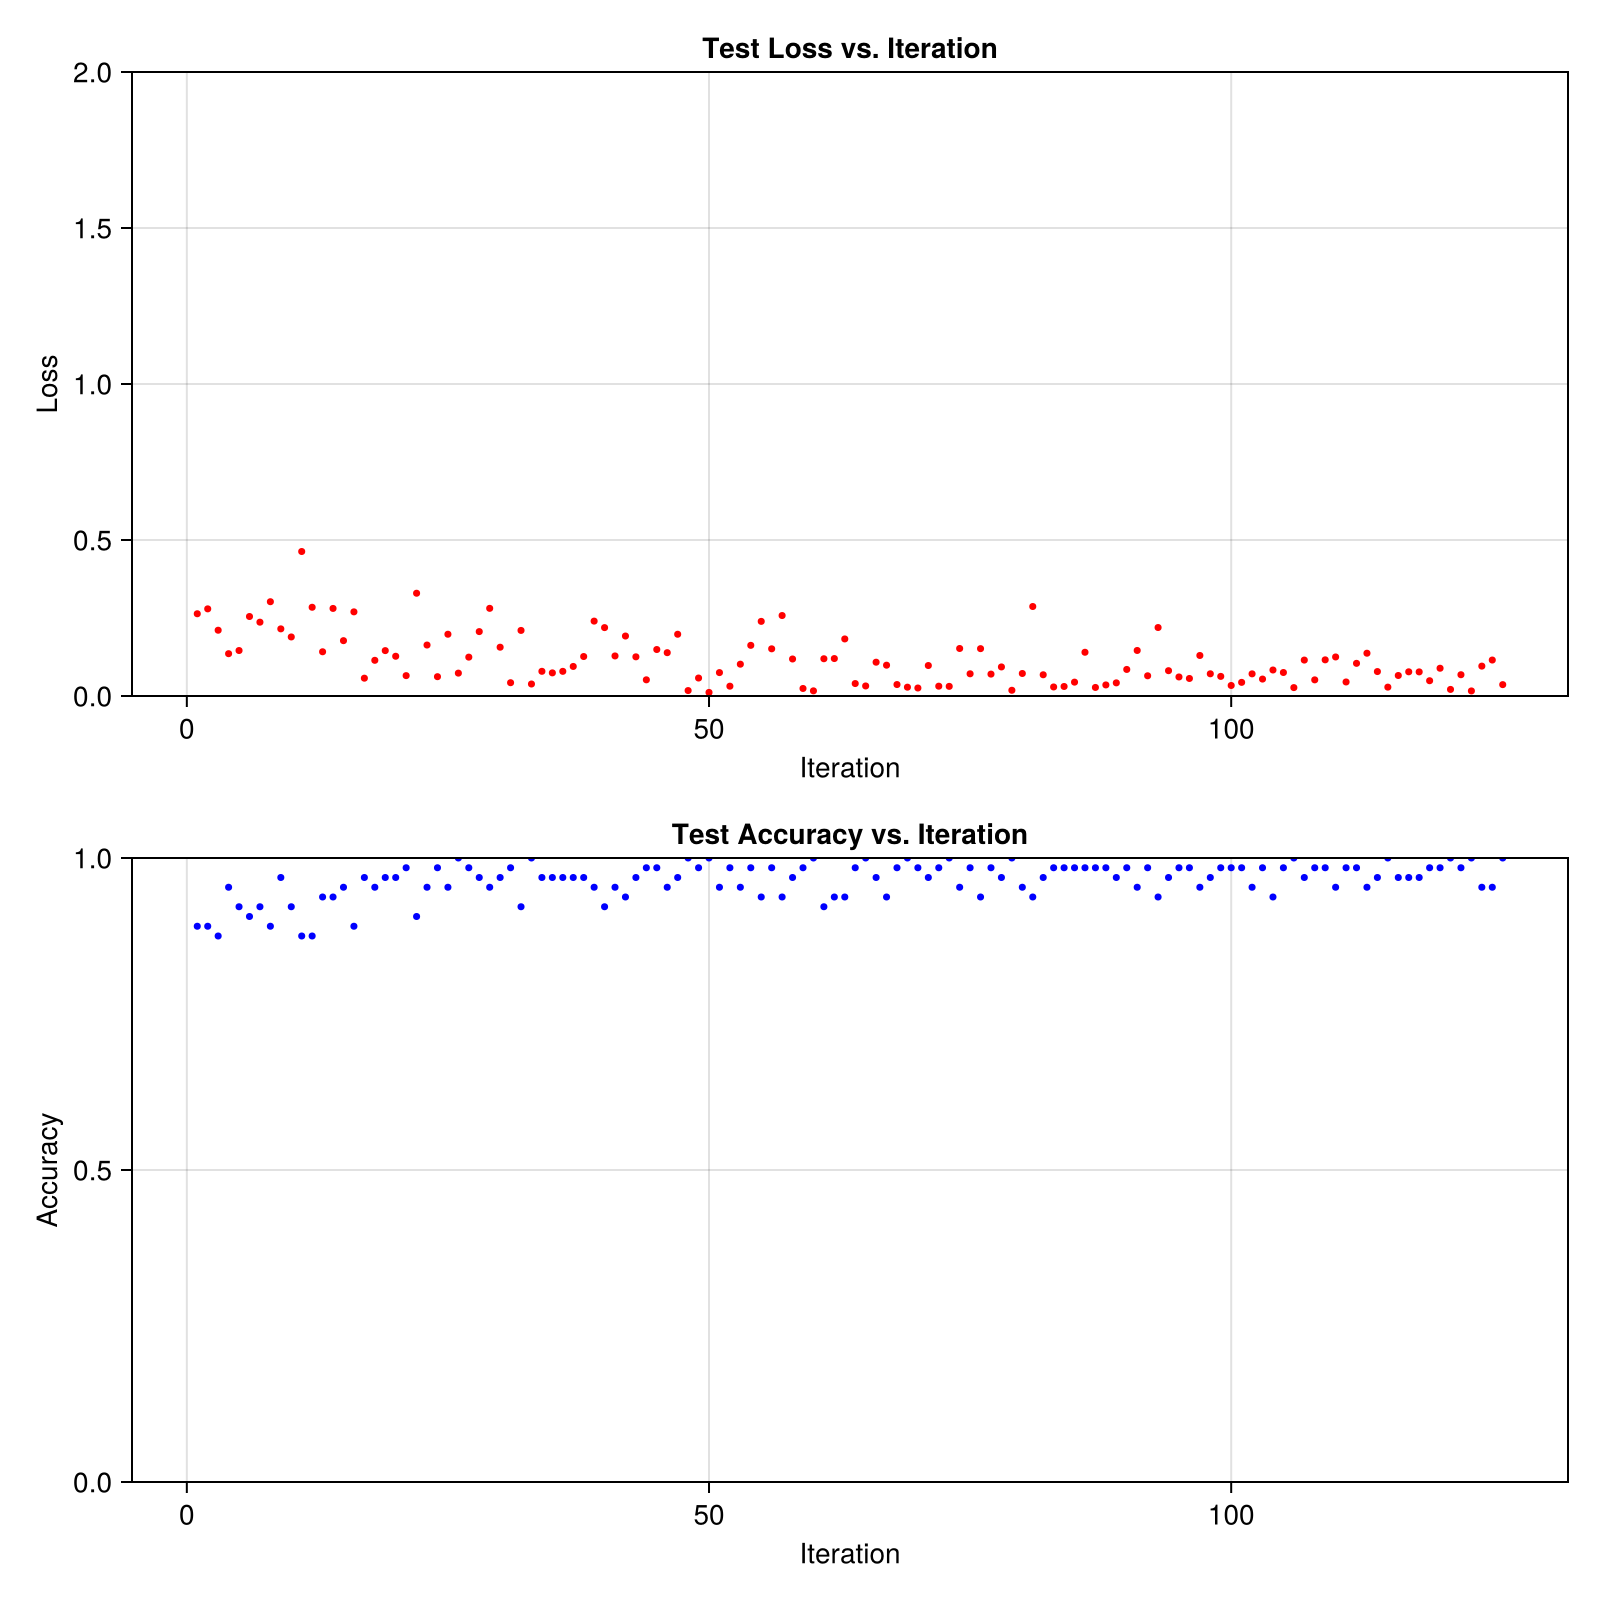

In [25]:
using CairoMakie

fig = Figure(size = (800, 800))
ax1 = Axis(
    fig[1, 1],
    xlabel = "Iteration",
    ylabel = "Loss",
    title = "Test Loss vs. Iteration"
)
ax2 = Axis(
    fig[2, 1],
    xlabel = "Iteration",
    ylabel = "Accuracy",
    title = "Test Accuracy vs. Iteration"
)

# Scatter plot the `vec_loss`
scatter!(ax1, vec_loss[1:10:end], color=:red, markersize=5)
ylims!(ax1, 0, 2)

# Scatter plot the `acc_loss`
scatter!(ax2, vec_acc[1:10:end], color=:blue, markersize=5)
ylims!(ax2, 0, 1)

# Display the figure
fig

Sampling from `test_loader` and comparison between predicted and actual outputs:

In [26]:
xs, ys = first(test_loader)
yp = xs |> lenet5 |> softmax |> out -> onecold(out, 0:9) |> cpu
ys = onecold(ys) .- 1 |> cpu;

In [27]:
idx = rand(1:HyperParams().batchsize, 8)
for i ∈ idx
    @info "**Prediction is $(yp[i]). Label is $(ys[i]).**"
end

[ Info: **Prediction is 3. Label is 3.**
[ Info: **Prediction is 7. Label is 7.**
[ Info: **Prediction is 3. Label is 3.**
[ Info: **Prediction is 2. Label is 2.**
[ Info: **Prediction is 4. Label is 4.**
[ Info: **Prediction is 5. Label is 5.**
[ Info: **Prediction is 9. Label is 9.**
[ Info: **Prediction is 2. Label is 2.**


## Save and Load

In [28]:
cnn_model = lenet5 |> cpu;

In [29]:
folder = "models"
isdir(folder) || mkdir(folder)

"models"

In [30]:
using Serialization

filename_1 = joinpath(folder, "cnn.jls")
serialize(filename_1, cnn_model)

In [31]:
using BSON

filename_2 = joinpath(folder, "cnn.bson")
BSON.@save filename_2 bson_mdl=cnn_model

In [32]:
using JLD2

filename_3 = joinpath(folder, "cnn.jld2")
JLD2.@save filename_3 jld2_mdl=cnn_model

In [33]:
# cnn_model = nothing

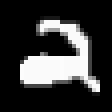

In [34]:
idx = rand(1:6000)
sample = d.features[:, :, idx] |> im -> reshape(im, (28, 28, 1, 1))
convert2image(d, idx)

In [35]:
stream_mdl = deserialize(filename_1)
pred = stream_mdl(sample) |> out -> (onecold(out) .- 1)[1]
print(d.targets[idx], ' ', pred)

2 2

In [36]:
BSON.@load filename_2 bson_mdl
pred = bson_mdl(sample) |> out -> (onecold(out) .- 1)[1]
print(d.targets[idx], ' ', pred)

2 2

In [37]:
JLD2.@load filename_3 jld2_mdl
pred = jld2_mdl(sample) |> out -> (onecold(out) .- 1)[1]
print(d.targets[idx], ' ', pred)

2 2